/Users/will/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of iterations: 0  loss: 0.43867317
Number of iterations: 1  loss: 0.021447487
Number of iterations: 2  loss: 0.019548204
Number of iterations: 3  loss: 0.019717492
Number of iterations: 4  loss: 0.02268711
Number of iterations: 5  loss: 0.022844177
Number of iterations: 6  loss: 0.020841312
Number of iterations: 7  loss: 0.01887243
Number of iterations: 8  loss: 0.017209183
Number of iterations: 9  loss: 0.016060617
Number of iterations: 10  loss: 0.015370233
Number of iterations: 11  loss: 0.015009786
Number of iterations: 12  loss: 0.014821657
Number of iterations: 13  loss: 0.014691435
Number of iterations: 14  loss: 0.014576789
Number of iterations: 15  loss: 0.014470801
Number of iterations: 16  loss: 0.014374567
Number of iterations: 17  loss: 0.014284592
Number of iterations: 18  loss: 0.01418814
Number of iterations: 19  loss: 0.014067244
Number of iterations: 20  loss: 0.013907228
Number of iterations: 21  loss: 0.013704916
Number of iterations: 22  loss: 0.013465708
Nu

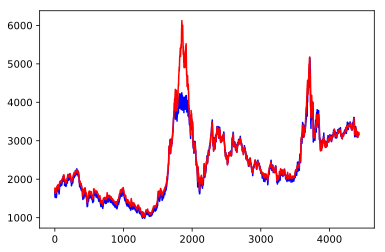

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

rnn_unit = 10  # 隐层数量
input_size = 5
output_size = 1
lr = 0.0006  # 学习率
batch_size = 60 #每一批次训练多少个样例
time_step = 20

# ——————————————————导入数据——————————————————————
f = open('stock.csv')
df = pd.read_csv(f)  # 读入股票数据
lable = df['high']
lable.drop([0],inplace=True)
lable = lable.reset_index()
lable.drop('index',axis=1,inplace=True)
df.drop([df.shape[0]-1],inplace=True)
df['predHigh'] = lable
data = df.iloc[:, 1:7].values  # 取第2-7列

# 获取训练集
def get_train_data(train_begin=0, train_end=4000):
    batch_index = []
    data_train = data[train_begin:train_end]
    normalized_train_data = (data_train - np.mean(data_train, axis=0)) / np.std(data_train, axis=0)  # 标准化
    train_x, train_y = [], []  # 训练集
    for i in range(len(normalized_train_data) - time_step):
        if i % batch_size == 0:
            batch_index.append(i)
        x = normalized_train_data[i:i + time_step, :5]
        y = normalized_train_data[i:i + time_step, 5, np.newaxis]
        train_x.append(x.tolist())
        train_y.append(y.tolist())
    batch_index.append((len(normalized_train_data) - time_step))
    return batch_index, train_x, train_y


# 获取测试集
def get_test_data(test_begin=4000):
    data_test = data[test_begin:]
    mean = np.mean(data_test, axis=0)
    std = np.std(data_test, axis=0)
    normalized_test_data = (data_test - mean) / std  # 标准化
    size = (len(normalized_test_data) + time_step - 1) // time_step  # 有size个sample
    test_x, test_y = [], []
    for i in range(size - 1):
        x = normalized_test_data[i * time_step:(i + 1) * time_step, :5]
        y = normalized_test_data[i * time_step:(i + 1) * time_step, 5]
        test_x.append(x.tolist())
        test_y.extend(y)
    test_x.append((normalized_test_data[(size-1) * time_step:, :5]).tolist())
    test_y.extend((normalized_test_data[(size-1) * time_step:, 5]).tolist())
    return mean, std, test_x, test_y



# ——————————————————定义神经网络变量——————————————————
# 输入层、输出层权重、偏置

weights = {
    'in': tf.Variable(tf.random_normal([input_size, rnn_unit])),
    'out': tf.Variable(tf.random_normal([rnn_unit, 1]))
}
biases = {
    'in': tf.Variable(tf.constant(0.1, shape=[rnn_unit, ])),
    'out': tf.Variable(tf.constant(0.1, shape=[1, ]))
}


# ——————————————————LSTM——————————————————
def lstm(X):
    batch_size = tf.shape(X)[0]
    time_step = tf.shape(X)[1]
    w_in = weights['in']
    b_in = biases['in']
    input = tf.reshape(X, [-1, input_size])  # 需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn = tf.matmul(input, w_in) + b_in
    input_rnn = tf.reshape(input_rnn, [-1, time_step, rnn_unit])  # 将tensor转成3维，作为lstm cell的输入
    cell = tf.nn.rnn_cell.BasicLSTMCell(rnn_unit)
    init_state = cell.zero_state(batch_size, dtype=tf.float32)
    output_rnn, final_states = tf.nn.dynamic_rnn(cell, input_rnn, initial_state=init_state, dtype=tf.float32)
    output = tf.reshape(output_rnn, [-1, rnn_unit])
    w_out = weights['out']
    b_out = biases['out']
    pred = tf.matmul(output, w_out) + b_out
    return pred, final_states


# ————————————————训练模型————————————————————

def train_lstm(train_begin=2000, train_end=5800):
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    Y = tf.placeholder(tf.float32, shape=[None, time_step, output_size])
    batch_index, train_x, train_y = get_train_data(train_begin, train_end)
    with tf.variable_scope("sec_lstm"):
        pred, _ = lstm(X)
    loss = tf.reduce_mean(tf.square(tf.reshape(pred, [-1]) - tf.reshape(Y, [-1])))
    train_op = tf.train.AdamOptimizer(lr).minimize(loss)
    saver = tf.train.Saver(tf.global_variables(), max_to_keep=15)

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(100):  # 这个迭代次数，可以更改，越大预测效果会更好，但需要更长时间
            for step in range(len(batch_index) - 1):
                _, loss_ = sess.run([train_op, loss], feed_dict={X: train_x[batch_index[step]:batch_index[step + 1]],
                                                                 Y: train_y[batch_index[step]:batch_index[step + 1]]})
            print("Number of iterations:", i, " loss:", loss_)
        print("model_save: ", saver.save(sess, 'model_save2/modle.ckpt'))
        # 我是在window下跑的，这个地址是存放模型的地方，模型参数文件名为modle.ckpt
        # 在Linux下面用 'model_save2/modle.ckpt'
        print("The train has finished")


train_lstm()


# ————————————————预测模型————————————————————
def prediction():
    X = tf.placeholder(tf.float32, shape=[None, time_step, input_size])
    mean, std, test_x, test_y = get_test_data(time_step)
    with tf.variable_scope("sec_lstm", reuse=True):
        pred, _ = lstm(X)
    saver = tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        # 参数恢复
        module_file = tf.train.latest_checkpoint('model_save2')
        saver.restore(sess, module_file)
        test_predict = []
        for step in range(len(test_x) - 1):
            prob = sess.run(pred, feed_dict={X: [test_x[step]]})
            predict = prob.reshape((-1))
            test_predict.extend(predict)
        test_y = np.array(test_y) * std[5] + mean[5]
        
        test_predict = np.array(test_predict) * std[5] + mean[5]
        #print(test_predict[-2, -1])
        acc = np.average(np.abs(test_predict - test_y[:len(test_predict)]) / test_y[:len(test_predict)])  # 偏差程度
        print("The accuracy of this predict:", acc)
        # 以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(test_predict))), test_predict, color='b', )
        plt.plot(list(range(len(test_y))), test_y, color='r')
        plt.show()


prediction()